In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-logistics-performance-dataset/logistics_shipments_dataset.csv


In [56]:
import pandas as pd
import numpy as np
from datetime import datetime
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt

In [57]:
file_path = "/kaggle/input/us-logistics-performance-dataset/logistics_shipments_dataset.csv"
df = pd.read_csv(file_path)

In [58]:
print("Initial shape:", df.shape)
df.columns

Initial shape: (2000, 11)


Index(['Shipment_ID', 'Origin_Warehouse', 'Destination', 'Carrier',
       'Shipment_Date', 'Delivery_Date', 'Weight_kg', 'Cost', 'Status',
       'Distance_miles', 'Transit_Days'],
      dtype='object')

In [59]:
df["Shipment_Date"] = pd.to_datetime(df["Shipment_Date"], errors="coerce")
df["Delivery_Date"] = pd.to_datetime(df["Delivery_Date"], errors="coerce")

In [60]:
df = df.dropna(subset=["Shipment_Date", "Delivery_Date"])

In [61]:
df["delay_days"] = (df["Delivery_Date"] - df["Shipment_Date"]).dt.days - df["Transit_Days"]
df["is_delayed"] = (df["delay_days"] > 0).astype(int)

In [62]:
df["Carrier"] = df["Carrier"].fillna("missing")
df["Weight_kg"] = df["Weight_kg"].fillna(df["Weight_kg"].median())
df["Distance_miles"] = df["Distance_miles"].fillna(df["Distance_miles"].median())
df["Cost"] = df["Cost"].fillna(df["Cost"].median())


In [63]:
df["ship_month"] = df["Shipment_Date"].dt.month
df["ship_dow"] = df["Shipment_Date"].dt.dayofweek

In [64]:
le_carrier = LabelEncoder()
df["carrier_enc"] = le_carrier.fit_transform(df["Carrier"])

le_origin = LabelEncoder()
df["origin_enc"] = le_origin.fit_transform(df["Origin_Warehouse"])

le_dest = LabelEncoder()
df["dest_enc"] = le_dest.fit_transform(df["Destination"])

In [65]:
features = [
    "Distance_miles", 
    "Weight_kg", 
    "Cost", 
    "Transit_Days", 
    "ship_month", 
    "ship_dow", 
    "carrier_enc", 
    "origin_enc", 
    "dest_enc"
]
target = "is_delayed"

X = df[features]
y = df[target]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [67]:
model = LGBMClassifier(random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 159, number of negative: 1415
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 829
[LightGBM] [Info] Number of data points in the train set: 1574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

In [68]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.3).astype(int)  

In [69]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       360
           1       0.07      0.15      0.10        34

    accuracy                           0.76       394
   macro avg       0.49      0.48      0.48       394
weighted avg       0.84      0.76      0.79       394



In [70]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


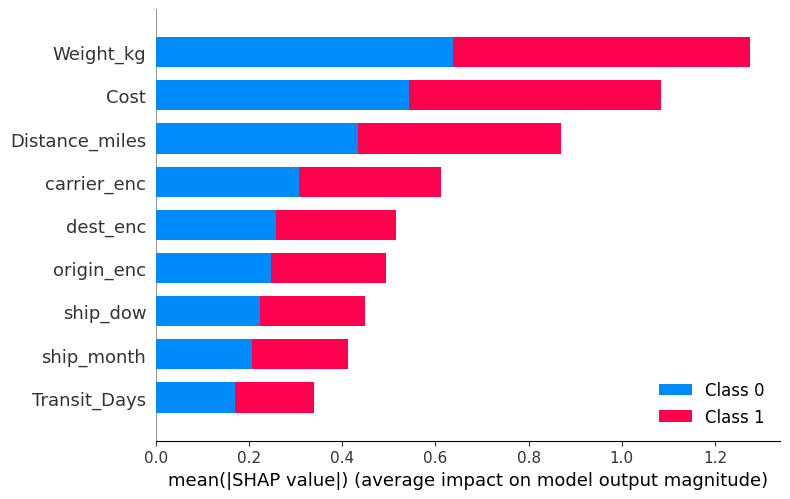

In [71]:
shap.summary_plot(shap_values, X_test, plot_type="bar")